# Preamble

In [101]:
using StaticArrays
using DifferentialEquations
using Random
using Distributions
using Plots
using LinearAlgebra
using CSV
using DataFrames

# Global parameters for testing

In [102]:
# Global parameters
N = 7  # Number of neurons
neurons = collect(1:N)  # Equivalent to Python's np.arange(0, N, 1)
outputn = [3]  # Output neuron
inputn = [1, 2]  # Input neurons

# Defining coupled neurons as a vector of vectors of coupled neurons
coupled_neurons = [collect(filter(x -> x != neuron, neurons)) for neuron in neurons]

# Defining and initializing weights matrix
weights_matrix = zeros(Float64, N, N)
for i in 2:N
    for j in 1:i-1
        weights_matrix[i, j] = randn()  # Normally distributed random weights
        weights_matrix[j, i] = weights_matrix[i, j]  # Symmetric weight matrix
    end
end

# Defining weights for each neuron for direct use
# Iterate over neurons and gather corresponding weights
weights = [weights_matrix[neuron, coupled_neurons[neuron]] for neuron in 1:N]  # .+ 1 to adjust for 1-based indexing

# Alpha and omega parameters (defined globally)
alpha = 1.0  # Defining alpha parameter
omega = zeros(Float64, N)  # Frequencies (initialized to zeros for now)
amplitude_relative = 1

1

# Evolution

In [103]:
function network_evolution!(
    dstate_dt::MVector{2 * N, Float64},  # Mutable vector to store derivatives
    state::MVector{2 * N, Float64},  # Mutable vector for state
    t::Float64,                  # Current time (for use in ODE solvers)
    W::Matrix{Float64},          # Coupling matrix
    alpha::Float64,              # Constant parameter
    omega::MVector{N, Float64},  # Mutable vector of frequencies with fixed size
    coupled_neurons::Vector{Vector{Int}},  # Vector of vectors for coupled neurons
    inputn::Vector{Int},         # Indices of input neurons
    coupled_values_den::Vector{Float64},   # Preallocated array for coupled densities
    coupled_values_phase::Vector{Float64}  # Preallocated array for coupled phases
)
    """
    Updates the derivatives of system parameters (densities and phases)
    
    This is an in-place update version of the previous function to reuse `dstate_dt`.
    It also reuses the preallocated `coupled_values_den` and `coupled_values_phase`.
    
    Parameters:
    - dstate_dt: Mutable vector to store the derivatives of state
    - state: Mutable vector containing densities and phases (rho_1, rho_2, ..., rho_n, theta_1, ..., theta_n)
    - t: Current time (not used but typical in ODE solving interfaces)
    - W: Coupling matrix
    - alpha: Constant parameter
    - omega: Mutable vector of frequencies for each neuron
    - coupled_neurons: Vector of vectors for neurons that are coupled
    - inputn: Vector of indices for input neurons (no evolution in input neurons)
    - coupled_values_den: Preallocated array to hold the densities of coupled neurons
    - coupled_values_phase: Preallocated array to hold the phases of coupled neurons
    
    Returns:
    - dstate_dt: Updated in place with the computed derivatives
    """
    for neuron in 1:N
        if neuron in inputn
            # For input neurons, the evolution of density and phase is zero
            dstate_dt[neuron] = 0.0
            dstate_dt[N + neuron] = 0.0
        else
            # Retrieve the coupled neuron indices for the current neuron
            coupled_idx = coupled_neurons[neuron]
            num_coupled = length(coupled_idx)
            
            # this should be a external function
            for i in 1:num_coupled
                coupled_values_den[i] = state[coupled_idx[i]]
                coupled_values_phase[i] = state[N + coupled_idx[i]]
            end

            # Evolution of densities and phases for non-input neurons
            dden_dt = -alpha * state[neuron]^3
            dden_dt += sum(W[neuron, coupled_idx] .* coupled_values_den[1:num_coupled] .* cos.(coupled_values_phase[1:num_coupled] .- state[N + neuron]))

            dphase_dt = omega[neuron] + sum(W[neuron, coupled_idx] .* coupled_values_den[1:num_coupled] ./ state[neuron] .* sin.(coupled_values_phase[1:num_coupled] .- state[N + neuron]))

            dstate_dt[neuron] = dden_dt
            dstate_dt[N + neuron] = dphase_dt
        end
    end

    return nothing  # In-place function doesn't return a new array
end

function network_evolution_nudge!(
    dstate_dt::MVector{2 * N, Float64},  # Mutable vector to store derivatives
    state::MVector{2 * N, Float64},  # Mutable vector for state
    t::Float64,                  # Current time (for use in ODE solvers)
    W::Matrix{Float64},          # Coupling matrix
    alpha::Float64,              # Constant parameter
    omega::MVector{N, Float64},  # Mutable vector of frequencies with fixed size
    coupled_neurons::Vector{Vector{Int}},  # Vector of vectors for coupled neurons
    inputn::Vector{Int},         # Indices of input neurons
    beta_den::MVector{N, Float64},
    beta_phase::MVector{N, Float64},
    coupled_values_den::Vector{Float64},   # Preallocated array for coupled densities
    coupled_values_phase::Vector{Float64}  # Preallocated array for coupled phases
)
    """
    Updates the derivatives of system parameters (densities and phases)
    
    This is an in-place update version of the previous function to reuse `dstate_dt`.
    It also reuses the preallocated `coupled_values_den` and `coupled_values_phase`.
    
    Parameters:
    - dstate_dt: Mutable vector to store the derivatives of state
    - state: Mutable vector containing densities and phases (rho_1, rho_2, ..., rho_n, theta_1, ..., theta_n)
    - t: Current time (not used but typical in ODE solving interfaces)
    - W: Coupling matrix
    - alpha: Constant parameter
    - omega: Mutable vector of frequencies for each neuron
    - coupled_neurons: Vector of vectors for neurons that are coupled
    - inputn: Vector of indices for input neurons (no evolution in input neurons)
    - coupled_values_den: Preallocated array to hold the densities of coupled neurons
    - coupled_values_phase: Preallocated array to hold the phases of coupled neurons
    
    Returns:
    - dstate_dt: Updated in place with the computed derivatives
    """
    for neuron in 1:N
        if neuron in inputn
            # For input neurons, the evolution of density and phase is zero
            dstate_dt[neuron] = 0.0
            dstate_dt[N + neuron] = 0.0
        else
            # Retrieve the coupled neuron indices for the current neuron
            coupled_idx = coupled_neurons[neuron]
            num_coupled = length(coupled_idx)
            
            # this should be a external function
            for i in 1:num_coupled
                coupled_values_den[i] = state[coupled_idx[i]]
                coupled_values_phase[i] = state[N + coupled_idx[i]]
            end

            # Evolution of densities and phases for non-input neurons
            dden_dt = -alpha * state[neuron]^3
            dden_dt += sum(W[neuron, coupled_idx] .* coupled_values_den[1:num_coupled] .* cos.(coupled_values_phase[1:num_coupled] .- state[N + neuron]))
            dden_dt += - beta_den[neuron].*(state[neuron].-target[neuron])

            dphase_dt = omega[neuron] + sum(W[neuron, coupled_idx] .* coupled_values_den[1:num_coupled] ./ state[neuron] .* sin.(coupled_values_phase[1:num_coupled] .- state[N + neuron]))
            dphase_dt += -beta_phase[neuron] * sin.(state[N + neuron] .- target[N + neuron]) ./ (cos.(state[N + neuron] .- target[N + neuron]) .+ 1 .+ 1e-8)


            dstate_dt[neuron] = dden_dt
            dstate_dt[N + neuron] = dphase_dt
        end
    end

    return nothing  # In-place function doesn't return a new array
end

# Corrected closure definition
network_evolution_closure = (du, u, p, t) -> network_evolution!(du, u, t, p[1], p[2], p[3], p[4], p[5], p[6], p[7])
network_evolution_nudge_closure = (du, u, p, t) -> network_evolution_nudge!(du, u, t, p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9])

# Function to plot distances and optionally save them
function plot_distances(distances_amp, distances; save=false)
    # Create a new plot with a 1x2 layout
    p = plot(layout = (1, 2), size = (1000, 400))

    # Plot amplitude distances in the first subplot
    plot!(p, distances_amp, label="Amplitude", color=:red, title="Amplitude distances", grid=true, xlabel="Index", ylabel="Distance", subplot=1)

    # Plot phase distances in the second subplot
    plot!(p, distances, label="Phase", color=:blue, title="Phase distances", grid=true, xlabel="Index", ylabel="Distance", subplot=2)

    # Display the plot
    display(p)  # Show the plot with both subplots

    # Save the plot as an image
    savefig(p, "XOR_SLNN_distances.png")

    # Optional: Save distances to a CSV file
    if save
        df = DataFrame(amplitude=distances_amp, phase=distances)
        CSV.write("XOR_SLNN_distances.csv", df)
        println("Distances saved to XOR_SLNN_distances.csv")
    end
end

function plot_network_evolution(solution, inputn, outputn; size=(800, 600), layout_position="vertical")
    t = solution.t  # Time points from the solution
    u = solution.u  # State variables (each u[i] is a vector at time t[i])
    
    # Helper function to get color based on index
    function get_color(idx, inputn, outputn)
        if idx in inputn
            return :red
        elseif idx in outputn
            return :blue
        else
            return :green
        end
    end

    # Plot elements 1-7 with interpolation from solution
    p1 = plot(title="amplitudes", xlabel="Time", ylabel="State Variables", legend=false, size=size)
    for i in 1:7
        color = get_color(i, inputn, outputn)
        plot!(p1, t, [u[j][i] for j in 1:length(t)], color=color, label="")
    end

    # Plot elements 8-14 with sine of the values
    p2 = plot(title="sine of phases", xlabel="Time", ylabel="State Variables", legend=false, size=size)
    for i in 8:14
        color = get_color(i-7, inputn, outputn)
        # Take the sine of the values for indices 8-14
        plot!(p2, t, [sin(u[j][i]) for j in 1:length(t)], color=color, label="")
    end

    # Layout: vertical (stacked) or horizontal (side by side)
    if layout_position == "vertical"
        layout = (2, 1)  # Up-Down (stacked layout)
    elseif layout_position == "horizontal"
        layout = (1, 2)  # Left-Right (side by side layout)
    else
        error("Invalid layout_position. Use 'vertical' or 'horizontal'.")
    end

    # Display both plots with the specified layout and size
    plot(p1, p2, layout=layout, size=size)
end 

function plot_network_evolution(states_temp, inputn, outputn, N; save_path1=nothing, save_path2=nothing)
    # Helper function to get color based on index
    function get_color(idx, inputn, outputn)
        if idx in inputn
            return :red
        elseif idx in outputn
            return :blue
        else
            return :green
        end
    end

    # First Figure: Plot first N elements of each solution
    fig1 = []
    for i in 1:4  # Create a 2x2 grid layout
        solution = states_temp[i]
        t = solution.t  # Time points from the solution
        u = solution.u  # State variables (each u[i] is a vector at time t[i])
        
        plot_i = plot(legend=false, size=(700, 700))
        for j in 1:N
            color = get_color(j, inputn, outputn)
            plot!(plot_i, t, [u[k][j] for k in 1:length(t)], color=color, label="")
        end
        push!(fig1, plot_i)
    end

    # Display the first figure with 4 subplots
    final_plot1 = plot(layout=(2, 2), fig1...)
    
    # Save the first figure if a save path is provided
    if save_path1 != nothing
        savefig(final_plot1, save_path1)
    end

    # Second Figure: Plot last N elements of each solution (sine-transformed)
    fig2 = []
    for i in 1:4  # Create a 2x2 grid layout
        solution = states_temp[i]
        t = solution.t  # Time points from the solution
        u = solution.u  # State variables (each u[i] is a vector at time t[i])
        
        plot_i = plot(legend=false, size=(700, 700))
        for j in (N+1):(2*N)
            color = get_color(j - N, inputn, outputn)
            plot!(plot_i, t, [sin(u[k][j]) for k in 1:length(t)], color=color, label="")
        end
        push!(fig2, plot_i)
    end

    # Display the second figure with 4 subplots
    final_plot2 = plot(layout=(2, 2), fig2...)
    
    # Save the second figure if a save path is provided
    if save_path2 != nothing
        savefig(final_plot2, save_path2)
    end

    return final_plot1, final_plot2
end


plot_network_evolution (generic function with 2 methods)

# Initialization and preallocation

In [104]:
# Example setup
dstate_dt = zeros(Float64, 2 * N)
init_densities = MVector{N, Float64}(rand(Uniform(-1, 1), N) / 2 .+ amplitude_relative)
init_phases = MVector{N, Float64}(rand(Uniform(-π, π), N))
state0 = MVector{2 * N, Float64}(vcat(init_densities, init_phases))

# Preallocate arrays for coupled densities and phases
max_coupled = maximum(length.(coupled_neurons))
coupled_values_den = zeros(Float64, max_coupled)
coupled_values_phase = zeros(Float64, max_coupled)

# Define omega as an SVector to match the function's expected type
omega_svec = MVector{N, Float64}(omega)

init_densities = [rand(-1.0:0.01:1.0)/2 for _ in 1:N] .+ amplitude_relative
init_phases = [2 * π * rand() - π for _ in 1:N] 
state0 = MVector{2 * N, Float64}(vcat(init_densities, init_phases))

params=(weights_matrix, alpha, omega_svec, coupled_neurons, inputn, coupled_values_den, coupled_values_phase)
t = 0.1
du = MVector{2 * N, Float64}(undef)

14-element MVector{14, Float64} with indices SOneTo(14):
  0.5
  1.5
  1.3245248152693798
  1.6521285914763173
  1.4178420177275737
  1.9755380053545373
  1.3276599879500655
 -0.13709076209847604
 -1.2466131226819634
  4.818013344239654
  4.753934014786477
  1.8231080330982719
  1.6433171465926213
  1.7707603644280028

  1.280345 seconds (4.98 M allocations: 236.750 MiB, 9.93% gc time, 99.11% compilation time)
single solving test done!

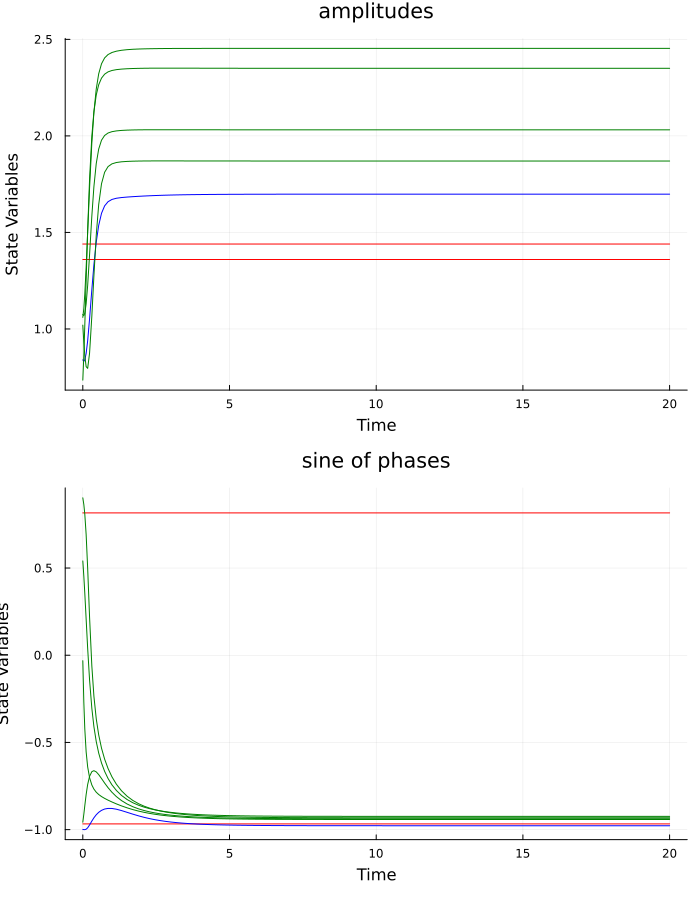

In [105]:
tspan = (0.0, 20.0)
# For better performance maybe homemade runge kuta algorithm would be better
problem = ODEProblem(network_evolution_closure, state0, tspan, (weights_matrix, alpha, omega_svec, coupled_neurons, inputn, coupled_values_den, coupled_values_phase))
@time solution = solve(problem, Tsit5(), reltol=1e-4, abstol=1e-4)
#@time solution = solve(problem, Tsit5(), saveat=0.01)
println("single solving test done!")
plot_network_evolution(solution, inputn, outputn; size=(700, 900), layout_position="vertical")

# XOR Dataset

In [107]:
amplitude_relative = 1
amplitude_fraction = 0.5
features_converted = [
    [-π, -π],
    [π, -π],
    [-π, π],
    [π, π]
] ./ 2.0
features_amp = [
    [-1.0 * amplitude_fraction + amplitude_relative, -1.0 * amplitude_fraction + amplitude_relative],
    [1.0 * amplitude_fraction + amplitude_relative, -1.0 * amplitude_fraction + amplitude_relative],
    [-1.0 * amplitude_fraction + amplitude_relative, 1.0 * amplitude_fraction + amplitude_relative],
    [1.0 * amplitude_fraction + amplitude_relative, 1.0 * amplitude_fraction + amplitude_relative]
] 
labels_converted = [-π, π, π, -π] ./ 2.0
labels_amp = [-1.0, 1.0, 1.0, -1.0] .* amplitude_fraction .+ amplitude_relative
features_original = [
    [0.0, 0.0],
    [1.0, 0.0],
    [0.0, 1.0],
    [1.0, 1.0]
]
features_original_label = ["0,0", "1,0", "0,1", "1,1"]
labels_original = [0.0, 1.0, 1.0, 0.0]

4-element Vector{Float64}:
 0.0
 1.0
 1.0
 0.0

# Learning parameters

In [108]:
gradient_weights_forward = zeros(N, N)
gradient_weights_backward = zeros(N, N)
weight_gradient = zeros(N, N)

# Holds normalized values of each gradient after 1 inference (used for debugging)
test_grad_vals = []

beta_den = MVector{N, Float64}(zeros(N))
beta_phase = MVector{N, Float64}(zeros(N))
# Set values for the output neurons
beta_den[outputn] .= 1e-6
#beta_phase[outputn] .= 1e-6

batch_size = 4
random_init_times = 1

inv_nudge_step_den = 1 ./ beta_den[outputn]
#inv_nudge_step_phase = 1 ./ beta_phase[outputn]
inv_batch_size = 1 / batch_size
inv_random_init_times = 1 / random_init_times



distances = []
distances_amp = []
costs = []
costs_amp = []

Any[]

# Temp init

In [114]:
# Example setup
dstate_dt = zeros(Float64, 2 * N)
init_densities = MVector{N, Float64}(rand(Uniform(-1, 1), N) / 2 .+ amplitude_relative)
init_phases = MVector{N, Float64}(rand(Uniform(-π, π), N))
state0 = MVector{2 * N, Float64}(vcat(init_densities, init_phases))

# Preallocate arrays for coupled densities and phases
max_coupled = maximum(length.(coupled_neurons))
coupled_values_den = zeros(Float64, max_coupled)
coupled_values_phase = zeros(Float64, max_coupled)

# Define omega as an SVector to match the function's expected type
omega_svec = MVector{N, Float64}(omega)

#init_densities = [rand(-1.0:0.01:1.0)/2 for _ in 1:N] .+ amplitude_relative
#init_phases = [2 * π * rand() - π for _ in 1:N] 
#state0 = MVector{2 * N, Float64}(vcat(init_densities, init_phases))

params=(weights_matrix, alpha, omega_svec, coupled_neurons, inputn, coupled_values_den, coupled_values_phase)
t = 0.1
du = MVector{2 * N, Float64}(undef)

14-element MVector{14, Float64} with indices SOneTo(14):
  0.0
  0.0
  4.6649067175135956e-7
  5.140984932123979e-7
  8.358785754069547e-8
 -1.0183638659211042e-6
  3.620315832157691e-8
  0.0
  0.0
  5.7193579725591325e-9
  4.292960275290672e-9
 -2.6945126100479103e-8
  1.9284554020562076e-9
 -6.327469580668107e-9

In [113]:
weights_matrix

7×7 Matrix{Float64}:
  0.0        -0.124877    0.259006  …   0.0327522  -0.258593    0.0935221
 -0.124877    0.0         0.627544     -0.0297635  -0.0923426   2.12863
  0.259006    0.627544   -3.47727      -0.283523   -0.977998   -0.416837
 -1.07311     2.2195      1.14006       0.059953    1.29698     1.40654
  0.0327522  -0.0297635  -0.283523     -0.0994691   0.0284591   2.12096
 -0.258593   -0.0923426  -0.977998  …   0.0284591  -0.34469     1.29691
  0.0935221   2.12863    -0.416837      2.12096     1.29691    -0.372295

Starting epoch number 10


Starting epoch number 20


Starting epoch number 30


Starting epoch number 40


Starting epoch number 50


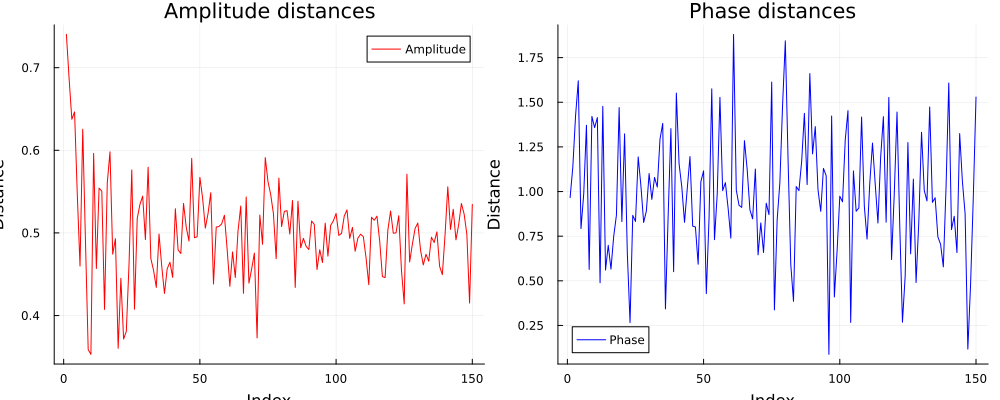

In [115]:
target = zeros(2 * N)
densities = zeros(N)
phases = zeros(N)

learning_rate = 1
num_of_epochs = 50
tspan = (0.,200.)
reltol = 1e-10
abstol = 1e-10
for epoch in 1:num_of_epochs

    if epoch % 10 == 0
        println("Starting epoch number $epoch")
    end

    # Reuse weight_gradient by resetting it to zero instead of creating a new matrix
    fill!(weight_gradient, 0.0)

    distance_temp = []
    distance_amp_temp = []
    cost_temp = []
    cost_amp_temp = []

    for (feature, feature_amp, label, label_amp) in zip(features_converted, features_amp, labels_converted, labels_amp)
        
        # Prepare target vector
        fill!(target, 0.0)
        target[outputn] .= label_amp

        # Insert input values and random initialization
        densities = copy(init_densities)  # Reuse init_densities  
        phases = [2 * π * rand() - π for _ in 1:N] # Reinitialize phases randomly
        
        densities[inputn[1]] = feature_amp[1]
        densities[inputn[2]] = feature_amp[2]
        #phases[inputn[1]] = feature[1]
        #phases[inputn[2]] = feature[2]

        state0 = MVector{2 * N, Float64}(vcat(densities, phases))  # Concatenate densities and phases into state vector

        # Calculating inference and inference energy
        problem = ODEProblem(network_evolution_closure, state0, tspan, (weights_matrix, alpha, omega_svec, coupled_neurons, inputn, coupled_values_den, coupled_values_phase))
        solution = solve(problem, Tsit5(), reltol=reltol, abstol=abstol, dense=false, save_everystep=false, save_start = false)

        # Extract final densities and phases from the simulation
        phases .= solution[end][N+1:2*N]
        densities .= solution[end][1:N]
        state0 .= MVector{2 * N, Float64}(vcat(densities, phases)) # possibly unnecesary

        # Calculate energy gradient over weights (forward)
        for i in 2:N
            for j in 1:i-1
                gradient_weights_forward[i, j] = -(densities[i] * densities[j])^3 * cos(phases[i] - phases[j])
                gradient_weights_forward[j, i] = gradient_weights_forward[i, j] # to be deleted
            end
        end

        # Calculating nudge of inference and its energy
        problem = ODEProblem(network_evolution_nudge_closure, state0, tspan, (weights_matrix, alpha, omega_svec, coupled_neurons, inputn, beta_den, beta_phase, coupled_values_den, coupled_values_phase))
        solution_back = solve(problem, Tsit5(), reltol=reltol, abstol=abstol, dense=false, save_everystep=false, save_start = false)
        # Extract final densities and phases from the nudge simulation
        phases .= solution_back[end][N+1:2*N]
        densities .= solution_back[end][1:N]

        # Calculate energy gradient over weights (backward)
        for i in 2:N
            for j in 1:i-1
                gradient_weights_backward[i, j] = -(densities[i] * densities[j])^3 * cos(phases[i] - phases[j])
                gradient_weights_backward[j, i] = gradient_weights_backward[i, j] # to be deleted
            end
        end

        # Calculate gradient
        weight_gradient .+= gradient_weights_backward .- gradient_weights_forward

        # Calculate distance and cost
        push!(distance_temp, sum(1 .- cos.(phases[outputn] .- label)))
        push!(distance_amp_temp, sum(abs.(densities[outputn] .- label_amp)))
        push!(cost_temp, -sum(log.(1 .+ cos.(phases[outputn] .- label))))
        push!(cost_amp_temp, sum((densities[outputn] .- label_amp).^2))
    end

    # Adjust weight gradients and store values
    weight_gradient .*= inv_batch_size * inv_random_init_times
    push!(distances, mean(distance_temp))
    push!(distances_amp, mean(distance_amp_temp))
    push!(costs, mean(cost_temp))
    push!(costs_amp, mean(cost_amp_temp))
    push!(test_grad_vals, norm(weight_gradient, 1) / 4)

    # Normalize gradient if necessary
    if true
        weight_gradient ./= norm(weight_gradient, 1)
    end

    weights_matrix -= learning_rate * weight_gradient
end

plot_distances(distances_amp, distances; save=false)  # set `save=true` to save to CSV



In [98]:
distance_temp = []
distance_amp_temp = []
cost_temp = []
cost_amp_temp = []
outphase_temp = []
states_temp = []
target = zeros(2 * N)

for (feature, feature_amp, label, label_amp) in zip(features_converted, features_amp, labels_converted, labels_amp)

    fill!(target, 0.0)
    target[outputn] .= label_amp
    densities = copy(init_densities)  # Reuse init_densities  
    phases = [2 * π * rand() - π for _ in 1:N] # Reinitialize phases randomly
    densities[inputn[1]] = feature_amp[1]
    densities[inputn[2]] = feature_amp[2]
    #phases[inputn[1]] = feature[1]
    #phases[inputn[2]] = feature[2]
    state0 = MVector{2 * N, Float64}(vcat(densities, phases)) 

    problem = ODEProblem(network_evolution_closure, state0, tspan, (weights_matrix, alpha, omega_svec, coupled_neurons, inputn, coupled_values_den, coupled_values_phase))
    solution = solve(problem, Tsit5(), reltol=1e-4, abstol=1e-4)

    push!(states_temp, solution)
    push!(distance_temp, sum(1 .- cos.(phases[outputn] .- label)))
    push!(distance_amp_temp, sum(abs.(densities[outputn] .- label_amp)))
    push!(cost_temp, -sum(log.(1 .+ cos.(phases[outputn] .- label))))
    push!(cost_amp_temp, sum((densities[outputn] .- label_amp).^2))
end
    
    

[0,0]	[1,0]
[0,1]	[1,1]


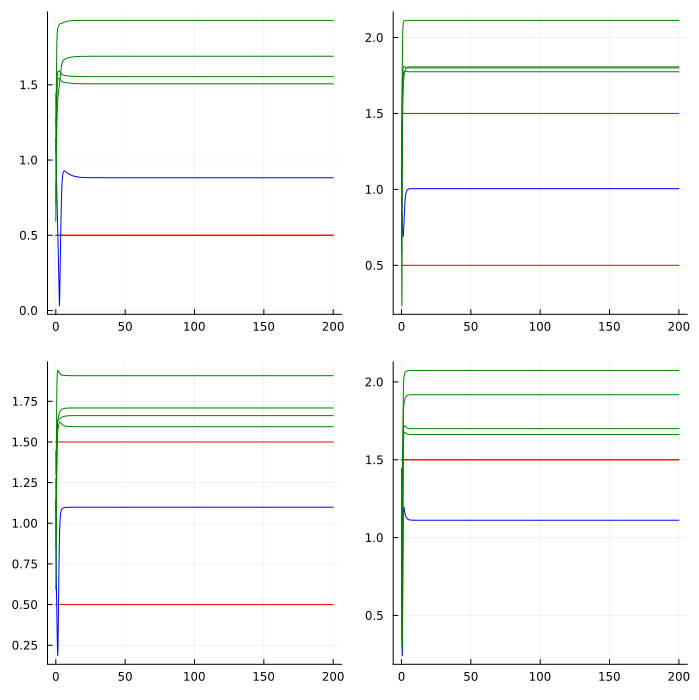

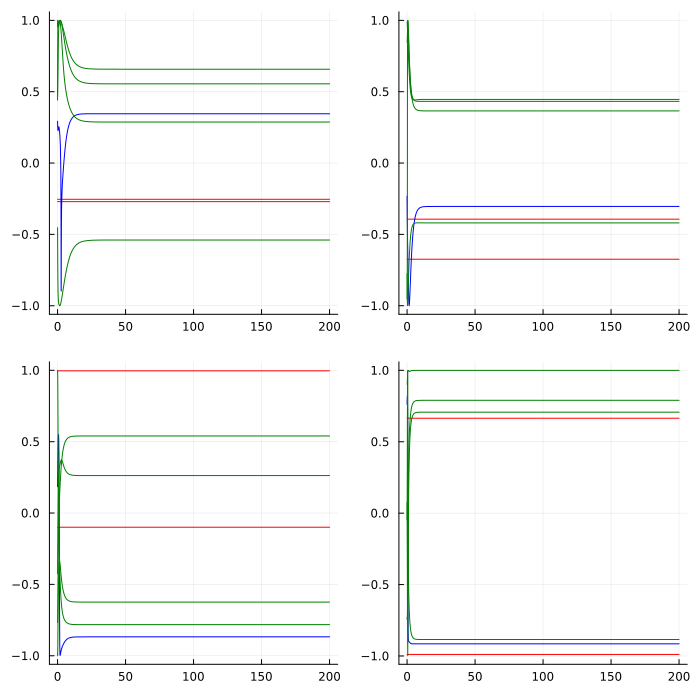

amplitudes
sin(phases):


In [99]:


# Example usage
final_plot1, final_plot2 = plot_network_evolution(states_temp, inputn, outputn, N, save_path1="network_evolution_1.png", save_path2="network_evolution_2.png")
println("[0,0]\t[1,0]\n[0,1]\t[1,1]")
println("amplitudes")
display(final_plot1)
println("sin(phases):")
display(final_plot2)

